### Customer Lifetime Value prediction

In [142]:
# !pip install numpy pandas scikit-learn lifetimes
import pandas as pd
import numpy as np
%matplotlib inline

In [143]:
df = pd.read_csv(filepath_or_buffer="./data/customer_segmentation.csv",
                 encoding="cp1252")  # Specify the encoding!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Convert the date field

In [144]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### Create a new field / feature from existing ones

In [145]:
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100 * date.year + date.month)
df['Revenue'] = df['UnitPrice'] * df['Quantity']  # This should be predicted!

In [146]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [147]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth,Revenue
count,541909.000000,541909,541909.000000,406829.000000,541909.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,201099.713989,17.987795
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,201012.000000,-168469.600000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,201103.000000,3.400000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,201107.000000,9.750000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,201110.000000,17.400000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,201112.000000,168469.600000
std,218.081158,NaN,96.759853,1713.600303,25.788703,378.810824


In [148]:
filtered = df.drop(columns=['StockCode', 'Description'])
filtered = filtered.dropna()

# keep only rows that make sens, i.e. are either definitely costs or definitely profits
filtered = filtered[
    (filtered['Revenue'] > 0) & (filtered['Quantity'] > 0) | (filtered['Revenue'] < 0) & (
                filtered['Quantity'] < 0)]

max_date = df['InvoiceDate'].max()
date_limit = max_date - pd.Timedelta(days=360)
filtered = filtered[filtered['InvoiceDate'] >= date_limit]



positive_revenue = filtered[filtered['Revenue'] >= 0]
positive_revenue = positive_revenue.drop_duplicates(subset=['InvoiceNo'], keep='first')

invoice_counts = positive_revenue['CustomerID'].value_counts()

customers_with_multiple_invoices = invoice_counts[invoice_counts >= 1.0].keys()

print(len(customers_with_multiple_invoices))
filtered_aux = filtered[filtered['CustomerID'].isin(customers_with_multiple_invoices)]

print(filtered_aux.head(5))
filtered_aux.shape

4246
      InvoiceNo  Quantity         InvoiceDate  UnitPrice  CustomerID Country  \
29732    538826        64 2010-12-14 12:58:00       2.55     12370.0  Cyprus   
29733    538826        10 2010-12-14 12:58:00       1.25     12370.0  Cyprus   
29734    538826        10 2010-12-14 12:58:00       1.25     12370.0  Cyprus   
29735    538826        10 2010-12-14 12:58:00       1.25     12370.0  Cyprus   
29736    538826        10 2010-12-14 12:58:00       1.25     12370.0  Cyprus   

       InvoiceYearMonth  Revenue  
29732            201012    163.2  
29733            201012     12.5  
29734            201012     12.5  
29735            201012     12.5  
29736            201012     12.5  


(387012, 8)

In [149]:
latest_buy = filtered_aux.groupby('CustomerID').InvoiceDate.max().reset_index()
earliest_buy = filtered_aux.groupby('CustomerID').InvoiceDate.min().reset_index()
latest_buy.columns = ['CustomerID','LatestBuyDate']
earliest_buy.columns = ['CustomerID','EarliestBuyDate']
latest_buy['Recency'] = (max_date - latest_buy['LatestBuyDate']).dt.days/35
latest_buy.drop(['LatestBuyDate'], axis=1, inplace=True)


purchase_dates = filtered_aux.groupby('CustomerID')['InvoiceDate'].unique()
frequency = purchase_dates.apply(len)
average_time_between_buys = purchase_dates.apply(lambda p: [(p[n] - p[n-1]).days for n in range(1, len(p))])
average_time_between_buys = average_time_between_buys.apply(lambda p: sum(p)/len(p) if len(p) > 1 else sum(p))

print(average_time_between_buys.describe())



revenue = filtered_aux.groupby('CustomerID').Revenue.sum().reset_index()
revenue = revenue[np.abs(revenue.Revenue - revenue.Revenue.mean()) < (3 * revenue.Revenue.std())]

final = pd.merge(revenue, frequency.to_frame(), on='CustomerID')
final = pd.merge(final, average_time_between_buys.to_frame(), on='CustomerID')

final['T'] = (max_date - earliest_buy['EarliestBuyDate']).dt.days/35
final.rename(columns={'InvoiceDate_x':'Frequency', 'InvoiceDate_y':'MeanTimeBetweenBuys'}, inplace=True)
final['Recency'] = latest_buy['Recency']
final = final[np.abs(final.Recency - final.Recency.mean()) < (3 * final.Recency.std())]
final = final[np.abs(final.MeanTimeBetweenBuys - final.MeanTimeBetweenBuys.mean()) < (3 * final.MeanTimeBetweenBuys.std())]
print(final[['Frequency', 'Revenue']].corr())
final.head(5)
final.describe()



count    4246.000000
mean       38.743297
std        52.166116
min         0.000000
25%         0.000000
50%        22.000000
75%        54.250000
max       356.000000
Name: InvoiceDate, dtype: float64
           Frequency  Revenue
Frequency     1.0000   0.7256
Revenue       0.7256   1.0000


,CustomerID,Revenue,Frequency,MeanTimeBetweenBuys,T,Recency
count,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000
mean,15284.546206,1414.581779,4.617218,33.564530,5.942454,2.390314
std,1721.013720,2262.052028,6.761559,40.170445,3.167601,2.621550
min,12346.000000,-1591.200000,1.000000,0.000000,0.000000,0.000000
25%,13802.750000,295.522500,1.000000,0.000000,2.828571,0.428571
50%,15275.500000,655.905000,3.000000,21.000000,6.800000,1.285714
75%,16766.250000,1601.110000,5.000000,52.000000,8.800000,3.607143
max,18287.000000,25658.870000,198.000000,195.000000,10.257143,10.257143


In [150]:
from lifetimes import ParetoNBDFitter



paretof = ParetoNBDFitter(penalizer_coef=0.001)
paretof.fit(final['Frequency'], final['Recency'], final['T'], iterative_fitting=1)

print(paretof)


C:\Users\Hamuul\.virtualenvs\fork\Lib\site-packages\scipy\optimize\_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


<lifetimes.ParetoNBDFitter: fitted with 4112 subjects, alpha: 0.05, beta: 11.36, r: 1.43, s: 1.20>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

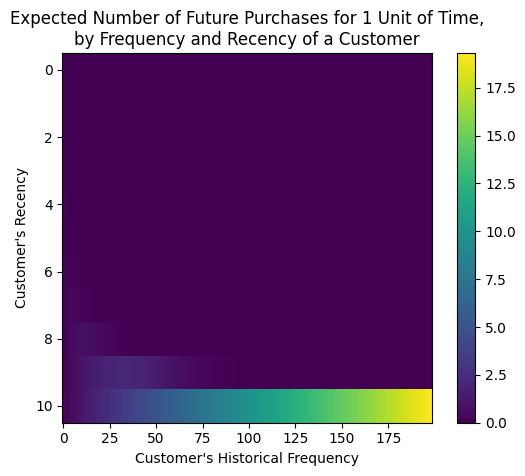

In [151]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix,  plot_period_transactions

plot_frequency_recency_matrix(paretof)


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

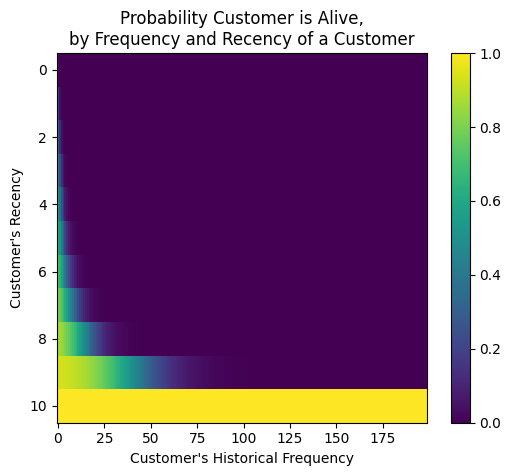

In [152]:
plot_probability_alive_matrix(paretof)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

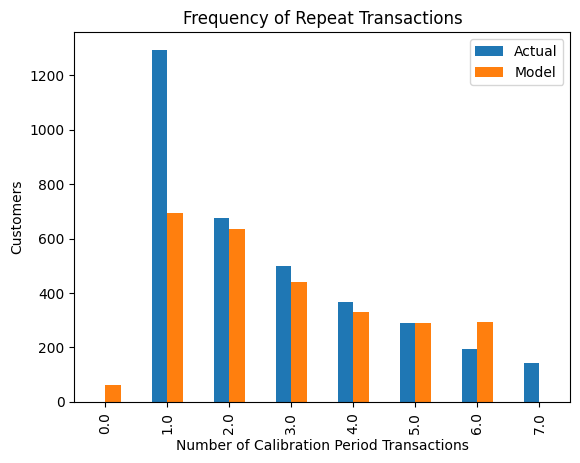

In [153]:
 plot_period_transactions(paretof)